## Chapter 6: Eligibility Traces

Eligibility traces are one of the basic mechanisms of reinforcement learning that aims to bridge Temporal Difference (TD) and Monte-Carlo (MC). 

Combined with TD methods such as Q-learning or SARSA, it can obtain a more general method that may learn more efficiently.



### TD$(\lambda)$

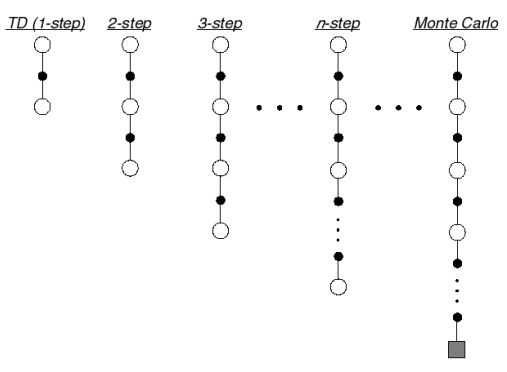

In Temporal-Difference value prediction, return $G_t$ is bootstrapped as the following:
</br>
</br>
<font size="3">
$$\begin{align}
G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-1} R_T = R_{t+1} + \gamma V(S_{t+1})
\end{align}$$
</font>

Return of state $S_t$ in MC is calculated at the end of the episode, and boostrapped return in TD is calculated after one step of $S_t$. 

#### n-step TD Prediction

We can think of intermediate version of return of TD and MC, that boostrapping is performed using multiple steps of returns. 
</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(n)} = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{n-1}R_{t+n} + \gamma^{n}V(S_{t+n})
\end{align}$$
</font>
which is named **n-step return**.

Using n-step return, n-step TD prediction can be done.
</br>
</br>
<font size="3">
$$\begin{align}
V(S_t) = V(S_t) + \alpha(G_t^{(n)} - V(S_t))
\end{align}$$
</font>


#### $\lambda$ - return

We can average n-step returns over different n, interrelating TD and Monte-Carlo methods.
$\lambda$-return is weighted average of all n-step returns $G_t^{(n)}$ with $\lambda \in [0, 1]$ as the following:
</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(\lambda)} = (1-\lambda) \sum_{n=1}^{\infty}[\lambda^{n-1}G_t^{(t + n)}] 
\end{align}$$
</font>

In $\lambda$-return, one-step return is given the largest weight $(1-\lambda)$, two-step is $(1-\lambda)\lambda$, and the three-step is $(1-\lambda)\lambda^2$, and so on. After a terminal state has been reached, all subsequent n-step returns are equal to $G_t$. If we want, we can separate these post-termination terms from the main sum, yielding

</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(\lambda)} = (1-\lambda) \sum_{n=1}^{T-t-1}[\lambda^{n-1}G_t^{(t + n)}] + \lambda^{T-t-1}G_t \\
= (1-\lambda)G_t^{(1)} + (1-\lambda)\lambda G_t^{(2)} + \cdots + \lambda^{T-t-1} G_t&
\end{align}$$
</font>

last term of $G_t^{(\lambda)}$ is set as $\lambda^{T-t-1} G_t^{T}$ because weights of n-step returns have to sum to 1. **$\lambda = 0$ is equivalent to TD-target, and $\lambda = 1$ is equivalent to Monte-Carlo return.** 

### Forward View of TD$(\lambda)$

There are two ways to view eligibility traces. The first one: forward view of TD$(\lambda)$ is a more theroetical view of eligibility traces. 

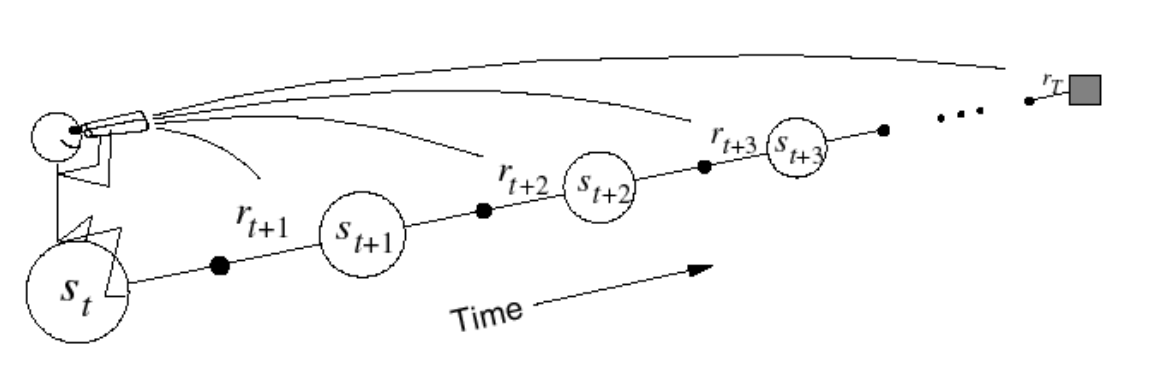
</br>
</br>
<font size="3">
$$\begin{align}
V(s_t) = V(s_t) + \alpha (G_t^\lambda - V(s_t))
\end{align}$$
</font>

Forward view of TD$(\lambda)$

- Update the value function toward the $\lambda$-return
- Looks into the future to compute $G_t^\lambda$
- Can only be computed from complete episode


### Backward View of TD$(\lambda)$

Backward view of TD$(\lambda)$ is a mechanistic view of eligibility traces. Unlike forward view of TD$(\lambda)$, backward view updates online, every step from incomplete episodes.

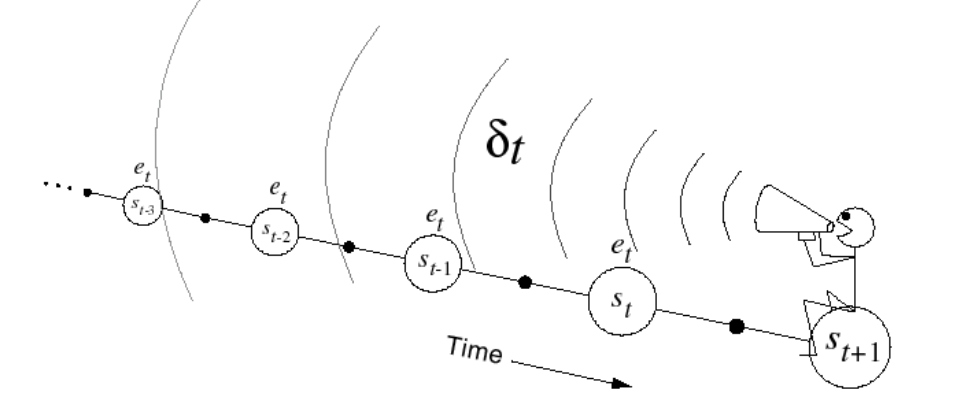

In backward view of TD($\lambda$), there exists additional variable named as **eligibility trace** in each state. The **Eligibility trace** for each state $s$ at time $t$ is a random variable denoted $E_t(s) \in \mathbb{E}^+$. On each step $t$, $E_t(s)$ is updated as following:
</br>
</br>
<font size="3">
$$\begin{align}
E_t(s) = \gamma \lambda E_{t-1}(s) + \mathbb{1}(S_t = s)
\end{align}$$
</font>

where $\gamma$ is the discount rate hyperparameter, and $\lambda$ the *trace-decay* hyperparameter. E_t(s) is incremented by **1** if state $S_t$ is visited at time $t$.

**Eligibility traces** keep a simple record of which states have recently been visited in terms of $\gamma\lambda$, in order to indicate the degree to which each state is eligible for the reinforcing event; **one-step TD errors**.

In backward view of TD$(\lambda)$, the TD errors propagate to all recently visitied states as the following.
</br>
</br>
<font size="3">
$$\begin{align}
V(s) = V(s) + \alpha \delta_t E_t(s), \quad \text{for all} \; s \in \mathcal{S}
\end{align}$$
</font>

where $\delta_t$ is TD-error, $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$.

### Pseudocode and Implementation of SARSA($\lambda$) (backward-view)

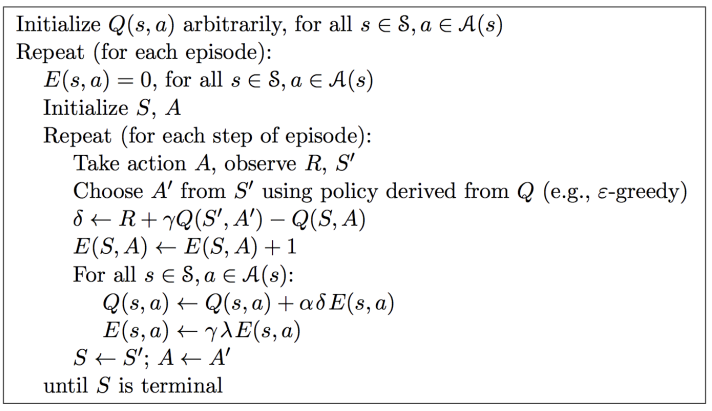

In [1]:
import gymnasium as gym
import numpy as np
from utils import JupyterRender

%matplotlib inline


In [2]:
class SARSA_lamda:
    def __init__(self, env, gamma=0.9, lamda=0.5, alpha=0.1,  eps=0.1, max_episode=100, render=False):
        self.env = env
                
        self.nrow = env.nrow
        self.ncol = env.ncol 
        
        self.state_dim = env.observation_space.n # self.nrow * self.ncol
        self.action_dim = env.action_space.n

        self.gamma = gamma
        self.lamda = lamda
        self.alpha = alpha
        self.eps = eps
        self.max_episode = max_episode
        self.render = render
        
        self.q = np.zeros([self.state_dim, self.action_dim])
    
    def action(self, s):
        #epsilon-greedy
        if np.random.random() < self.eps:
            action = np.random.randint(low=0, high=self.action_dim - 1)
        else:
            action = np.argmax(self.q[s,:])

        return action
    
    def run(self):
        self.success = 0
        for episode in range(self.max_episode):
            eligibility = np.zeros([self.state_dim, self.action_dim])
            
            observation, _ = self.env.reset()
            action = self.action(observation)

            done = False
            
            episode_reward = 0
            local_step = 0
            
            while not done:
                next_observation, reward, done, _, _ = self.env.step(action)
                
                if self.render:
                    self.env.render(title=f"Episode {episode} / step {local_step}", q=self.q)
                    
                # give penalty for staying in ground
                if reward == 0:
                    reward = -0.001
                    
                # give penalty for falling into the hole
                if done and next_observation != 15:
                    reward = -1

                if local_step == 100:
                    done = True #prevent infinite episode
                    reward = -1

                if observation == next_observation: # prevent meaningless actions
                    reward = -1

                next_action = self.action(next_observation)
                
                delta = reward + self.gamma * self.q[next_observation, next_action] - self.q[observation, action]
                eligibility[observation, action] += 1
                
                # eligibility update
                for i in range(self.state_dim):
                    for j in range(self.action_dim):
                        self.q[i, j] += self.alpha * delta *  eligibility[i, j]
                        eligibility[i, j] = self.gamma * self.lamda * eligibility[i, j] 
                        
                observation = next_observation
                action = next_action
                
                episode_reward += reward
                local_step += 1
                
            
            #print("Episode: {} -> Step: {}, Episode_reward: {}".format(episode, local_step, episode_reward))
            
            if observation == 15:
                self.success += 1
                
        #print("Success rate: ", success / self.max_episode)

In [3]:
env = gym.make("FrozenLake-v1", render_mode='rgb_array', is_slippery=False)#define the environment.
env = JupyterRender(env)

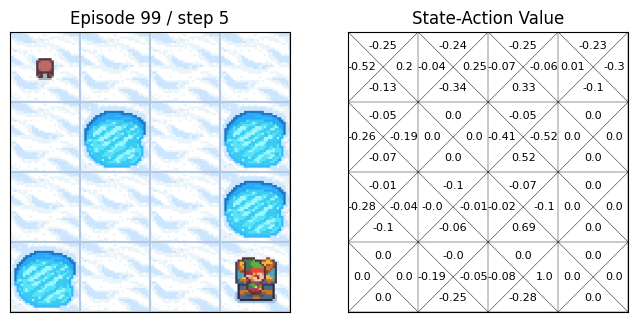

In [4]:
sarsa_lamda_config = {
    'env': env,
    'gamma': 0.8,
    'lamda': 0.5,
    'alpha': 0.1,
    'eps': 0.1,
    'render': True,
    'max_episode': 100
}

sarsa_lamda = SARSA_lamda(**sarsa_lamda_config)
sarsa_lamda.run()

### TD($\lambda$) and TD(0), MC

#### TD($\lambda$) and TD(0)
In forward view of TD($\lambda$), $\lambda$-return becomes $G_t^{(1)}$, which is
</br>
</br>
<font size="3">
$$\begin{align}
G_t^{(1)} = R_t + \gamma V(S_{t+1})
\end{align}$$
</font>

equal to TD-target in TD(0).

In backward view, when $\lambda = 0$, Eligibility trace $E_t(s)$ becomes
</br>
</br>
<font size="3">
$$\begin{align}
E_t(s) = \mathbb{1}(S_t = s)
\end{align}$$
</font>

and the TD errors only propagate to current state $s_t$.
</br>
</br>
<font size="3">
$$\begin{align}
V(s) = V(s) + \alpha \delta_t, \quad \text{for all} \; s \in \mathcal{S}
\end{align}$$
</font>

#### TD($\lambda$) and MC

If $\lambda = 1$, then $\lambda$-return becomes Monte-carlo return. 
</br>
</br>
<font size="3">
$$\begin{align}
G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-1} R_T
\end{align}$$
</font>

Thus forward-view of TD(1) is equivalent to Monte-carlo algorithm.

In backward-view of TD($\lambda$), if $\lambda = 1$ then eligibility trace $E_t(s)$ becomes
</br>
</br>
<font size="3">
$$\begin{align}
E_t(s) = \gamma E_{t-1}(s) + \mathbb{1}(S_t = s)
\end{align}$$
</font>

if state is visited once at $t = k$, then $E_t(s) = \gamma^{t-k}$ if $t \geq k$, and $E_t(s) = 0$ if $t < k$.

Then accumulated error of state $s$ at the end of the episode is
</br>
</br>
<font size="3">
$$\begin{align}
\sum_{t=1}^{T-1} \alpha \delta_t E_t(s) = \alpha \sum_{t=1}^{T-1} \gamma^{t-k} \delta_t = \alpha (G_t - V(S_t))
\end{align}$$
</font>

which is equivalent to **every-visit Monte-Carlo**. Therefore TD($\lambda$) is equivalent to MC if value function is updated **offline**; at the end of the episode.

If TD($\lambda$) is updated each step within episodes or **online**, then value function changes and foward TD($\lambda$) is **not in line with** backward TD($\lambda$).

If updated **online**, forward TD($\lambda$) and backward TD($\lambda$) is equivalent only when $\lambda = 0$.